In [1]:
import sys
sys.path.insert(0,'../code')

In [2]:
import torch
import matplotlib.pyplot as plt

from datamodules.image_classification import CIFAR10DataModule
from transformers import ViTFeatureExtractor, ViTForImageClassification
from models.interpretation import ImageInterpretationNet
from attributions.grad_cam import grad_cam
from attributions.attention_rollout import attention_rollout
from attributions.chefer import chefer_attributions
from utils.plot import smoothen, draw_mask_on_image, draw_heatmap_on_image, unnormalize
from datamodules.transformations import UnNest
import cv2

/home/angelos/anaconda3/envs/dl2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load images and model

In [3]:
# vit = ViTForImageClassification.from_pretrained("tanlq/vit-base-patch16-224-in21k-finetuned-cifar10")
vit = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

diffmask_cifar = ImageInterpretationNet.load_from_checkpoint('../checkpoints/diffmask.ckpt')
diffmask_cifar.set_vision_transformer(vit)

diffmask_imagenet = ImageInterpretationNet.load_from_checkpoint('../checkpoints/6.ckpt')
diffmask_imagenet.set_vision_transformer(vit)

# feature_extractor=ViTFeatureExtractor.from_pretrained(
#     "tanlq/vit-base-patch16-224-in21k-finetuned-cifar10", return_tensors="pt"
# )

feature_extractor=ViTFeatureExtractor.from_pretrained(
    "google/vit-base-patch16-224", return_tensors="pt"
)
feature_extractor = UnNest(feature_extractor)

In [4]:
num_images = 6
images = []
for i in range(num_images):
    img = cv2.imread(f'imagenet/image_{i+1}.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.tensor(img).permute(2,0,1)
    img = feature_extractor(img)    
    images.append(img)
    
images = torch.stack(images)
labels = diffmask_imagenet(images).softmax(-1).argmax(-1)

print([vit.config.id2label[label.item()] for label in labels])

images.requires_grad = True

rgb_images = [img.permute(1, 2, 0) for img in unnormalize(images)]  


['comic book', 'warplane, military plane', 'macaque', 'schooner', 'French loaf', 'Egyptian cat']


In [5]:
gradcam_masks = grad_cam(images, vit)

chefer_masks = [chefer_attributions(vit, img) for img in images]

X_attention_rollout = images.clone()
B, C, H, W = X_attention_rollout.shape
X_attention_rollout = torch.cat([torch.zeros(1, C, H, W), X_attention_rollout], dim=0)
rollout_masks = attention_rollout(X_attention_rollout, vit=vit)
rollout_masks = rollout_masks[1:]


masks_cifar = diffmask_cifar.get_mask(images)["mask"].detach()
masks_imagenet = diffmask_imagenet.get_mask(images)["mask"].detach()

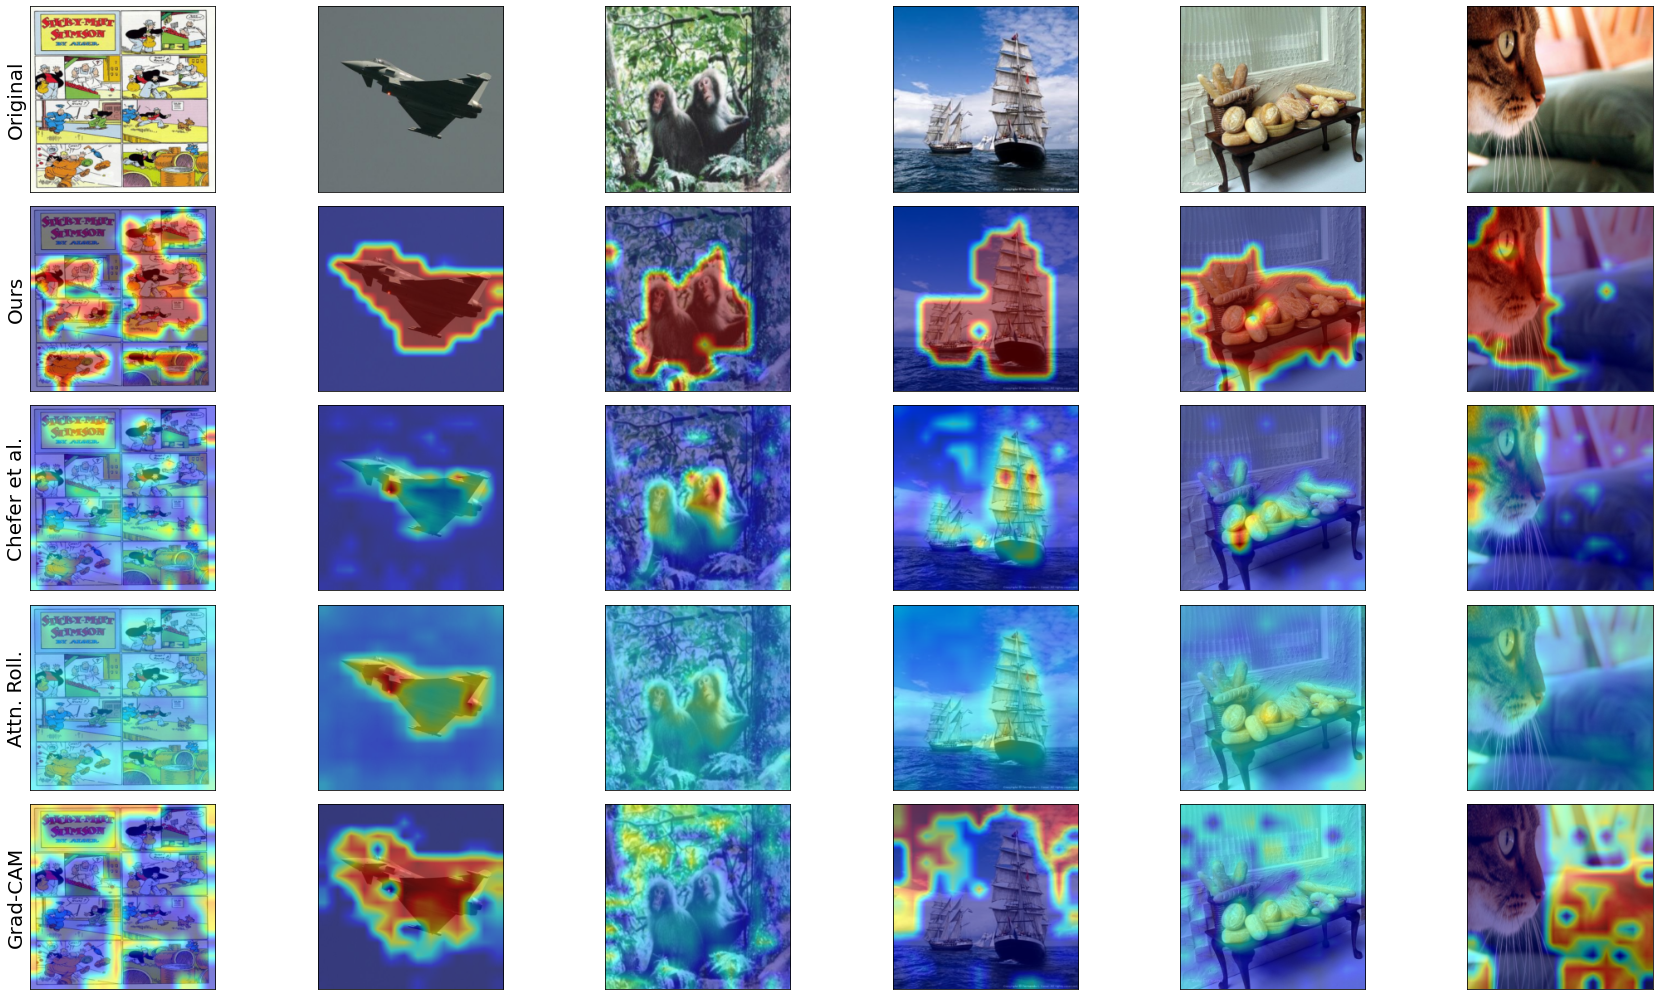

In [6]:
draw_mask = lambda image, mask: draw_mask_on_image(image.permute(2, 0, 1), mask).permute(1, 2, 0).clip(0, 1).numpy()
draw_heatmap = lambda image, mask: draw_heatmap_on_image(image.permute(2, 0, 1), mask).permute(1, 2, 0).clip(0, 1).numpy()

num_rows = 5 
fig, ax = plt.subplots(num_rows, num_images, figsize=(25, 14))

# Remove axes
for i in range(num_rows):
    for j in range(num_images):
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

font_size = 20
for i in range(num_images):
    # Original image
    if i == 0:
        ax[0, i].set_ylabel("Original", fontsize=font_size)
#         ax[1, i].set_ylabel("Ours CIFAR", fontsize=font_size)
        ax[1, i].set_ylabel("Ours", fontsize=font_size)
        ax[2, i].set_ylabel("Chefer et al.", fontsize=font_size)
        ax[3, i].set_ylabel("Attn. Roll.", fontsize=font_size)
        ax[4, i].set_ylabel("Grad-CAM", fontsize=font_size)

        
    ax[0, i].imshow(rgb_images[i])
#     ax[1, i].imshow(draw_heatmap(rgb_images[i], smoothen(masks_cifar[i].detach())))  
    ax[1, i].imshow(draw_heatmap(rgb_images[i], smoothen(masks_imagenet[i].detach())))
    ax[2, i].imshow(draw_heatmap(rgb_images[i], chefer_masks[i]))
    ax[3, i].imshow(draw_heatmap(rgb_images[i], smoothen(rollout_masks[i])))
    ax[4, i].imshow(draw_heatmap(rgb_images[i], gradcam_masks[i]))

fig.tight_layout()
fig.savefig("imagenet.png", dpi=300)
